In [8]:

# If you run on a fresh environment uncomment this:
%pip install -q pandas numpy matplotlib seaborn scikit-learn joblib

import os
import pandas as pd
import numpy as np

# attempt multiple likely locations for dataset.csv
candidates = [
    "notebooks/dataset.csv",
    "./notebooks/dataset.csv",
    "dataset.csv",
    "../notebooks/dataset.csv",
    "AT2_EXP-main/notebooks/dataset.csv"
]
DATA_PATH = None
for p in candidates:
    if os.path.exists(p):
        DATA_PATH = p
        break

if DATA_PATH is None:
    raise FileNotFoundError(
        "dataset.csv not found. Put it in notebooks/ or the same folder as this notebook, or set DATA_PATH."
    )

df = pd.read_csv(DATA_PATH, parse_dates=["date"])
print("Loaded:", DATA_PATH)
print("Rows, cols:", df.shape)
df.head()


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Loaded: dataset.csv
Rows, cols: (358, 12)


,date,dayofyear_sin,dayofyear_cos,precip_last_1,precip_last_3,precip_last_7,temp_max_mean_7,temp_min_mean_7,precip_hours_last_7,weathercode,will_rain_plus7,precip_next_3days
0,2023-01-01,0.017202,0.999852,10.293861,10.293861,10.293861,18.529584,5.323336,6,61,0,16.87
1,2023-01-02,0.034398,0.999408,0.000000,10.293861,10.293861,17.167908,4.973973,6,80,0,21.43
2,2023-01-03,0.051584,0.998669,13.354692,23.648553,23.648553,17.102202,4.723854,13,1,0,17.36
3,2023-01-04,0.068755,0.997634,3.516915,16.871607,27.165467,17.703014,4.664940,17,61,1,13.84
4,2023-01-05,0.085906,0.996303,4.557101,21.428708,31.722568,17.916828,4.288141,20,63,0,9.28


In [9]:
# features originally used in experiments (keep consistent)
FEATURE_COLS = [
    "dayofyear_sin","dayofyear_cos",
    "precip_last_1","precip_last_3","precip_last_7",
    "temp_max_mean_7","temp_min_mean_7",
    "precip_hours_last_7","weathercode"
]
# ensure columns exist
FEATURE_COLS = [c for c in FEATURE_COLS if c in df.columns]
print("Using features:", FEATURE_COLS)


Using features: ['dayofyear_sin', 'dayofyear_cos', 'precip_last_1', 'precip_last_3', 'precip_last_7', 'temp_max_mean_7', 'temp_min_mean_7', 'precip_hours_last_7', 'weathercode']


In [10]:
# correlation (numerical only)
corrs = df[FEATURE_COLS + ["precip_next_3days"]].select_dtypes(include=np.number).corr()
print("Top correlations with precip_next_3days:\n", corrs["precip_next_3days"].abs().sort_values(ascending=False).head(10))


Top correlations with precip_next_3days:
 precip_next_3days      1.000000
dayofyear_cos          0.421840
temp_min_mean_7        0.420471
temp_max_mean_7        0.419618
precip_last_7          0.208316
precip_last_3          0.206300
precip_hours_last_7    0.188465
precip_last_1          0.104735
dayofyear_sin          0.077350
weathercode            0.003418
Name: precip_next_3days, dtype: float64


In [11]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split

# prepare basic X (get_dummies for weathercode), minimal preprocessing
def prepare_X(df_in, features):
    X = df_in[features].copy()
    if "weathercode" in X.columns:
        X = pd.get_dummies(X, columns=["weathercode"], prefix="wc")
    return X

# quick train-test split for importance fishing
X = prepare_X(df, FEATURE_COLS)
y_clf = df["will_rain_plus7"]
y_reg = df["precip_next_3days"]

# split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42, stratify=y_clf)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# align columns (in case categories differ between splits)
X_train_clf, X_test_clf = X_train_clf.align(X_test_clf, join='left', axis=1, fill_value=0)
X_train_reg, X_test_reg = X_train_reg.align(X_test_reg, join='left', axis=1, fill_value=0)

clf_tmp = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
clf_tmp.fit(X_train_clf, y_train_clf)
imp_clf = pd.Series(clf_tmp.feature_importances_, index=X_train_clf.columns).sort_values(ascending=False)
print("Top classifier features:\n", imp_clf.head(10))

reg_tmp = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
reg_tmp.fit(X_train_reg, y_train_reg)
imp_reg = pd.Series(reg_tmp.feature_importances_, index=X_train_reg.columns).sort_values(ascending=False)
print("\nTop regression features:\n", imp_reg.head(10))


Top classifier features:
 dayofyear_cos          0.176996
temp_max_mean_7        0.159215
temp_min_mean_7        0.149987
dayofyear_sin          0.130238
precip_last_7          0.095187
precip_last_3          0.067878
precip_hours_last_7    0.065305
precip_last_1          0.036581
wc_63                  0.024038
wc_2                   0.018299
dtype: float64

Top regression features:
 dayofyear_cos          0.231514
temp_max_mean_7        0.186776
dayofyear_sin          0.176772
temp_min_mean_7        0.133433
precip_last_7          0.077163
precip_last_3          0.074892
precip_hours_last_7    0.036860
precip_last_1          0.029896
wc_0                   0.015719
wc_1                   0.010082
dtype: float64


In [12]:
# show missing count
print("Missing per column:\n", df[FEATURE_COLS + ["will_rain_plus7","precip_next_3days"]].isnull().sum())
# for simplicity, drop rows with missing features
df = df.dropna(subset=FEATURE_COLS + ["will_rain_plus7","precip_next_3days"])
print("After dropping NA rows:", df.shape)

Missing per column:
 dayofyear_sin          0
dayofyear_cos          0
precip_last_1          0
precip_last_3          0
precip_last_7          0
temp_max_mean_7        0
temp_min_mean_7        0
precip_hours_last_7    0
weathercode            0
will_rain_plus7        0
precip_next_3days      0
dtype: int64
After dropping NA rows: (358, 12)


# E.2 Data type fixes

In [13]:
# ensure numeric types
for c in FEATURE_COLS:
    if df[c].dtype == 'object':
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Scaling / transformation note

Note: For tree-based models scaling is not required. If using linear models or distance-based models in future, apply StandardScaler to numeric columns.

# F. Feature Engineering
* F.1 Recent-precip mean and flags

In [14]:
# simple engineered features
df["precip_recent_mean"] = df[["precip_last_1","precip_last_3","precip_last_7"]].mean(axis=1)
df["precip_any_last1"] = (df["precip_last_1"] > 0).astype(int)

# F.2 Temperature range (if max/min present)

In [15]:
if "temp_max_mean_7" in df.columns and "temp_min_mean_7" in df.columns:
    df["temp_week_range"] = df["temp_max_mean_7"] - df["temp_min_mean_7"]

# Final engineered column list

In [16]:
ENG_FEATURES = ["precip_recent_mean","precip_any_last1"]
if "temp_week_range" in df.columns:
    ENG_FEATURES.append("temp_week_range")

ALL_FEATURES = FEATURE_COLS + ENG_FEATURES
ALL_FEATURES = [c for c in ALL_FEATURES if c in df.columns]
print("Final feature list length:", len(ALL_FEATURES))

Final feature list length: 12


# G. Data Preparation for Modeling
* G.1 Split Datasets (classification & regression prep)

In [17]:
from sklearn.model_selection import train_test_split

X_clf = prepare_X(df, ALL_FEATURES)
y_clf = df["will_rain_plus7"].astype(int)
X_reg = prepare_X(df, ALL_FEATURES)
y_reg = df["precip_next_3days"].astype(float)

X_clf, _ = X_clf.align(X_reg, join='outer', axis=1, fill_value=0)  
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)
X_train_clf, X_test_clf = X_train_clf.align(X_test_clf, join='left', axis=1, fill_value=0)
X_train_reg, X_test_reg = X_train_reg.align(X_test_reg, join='left', axis=1, fill_value=0)

print("Classifier train/test sizes:", X_train_clf.shape, X_test_clf.shape)
print("Regression train/test sizes:", X_train_reg.shape, X_test_reg.shape)

Classifier train/test sizes: (286, 18) (72, 18)
Regression train/test sizes: (286, 18) (72, 18)


# G.2 Data transformation for modeling (no scaling required for RF)

We will use RandomForest models (no scaling needed). If using models requiring scaling, apply StandardScaler to numeric columns and save the scaler artifact.

# H. Save Datasets & Models
* H.1 Train & Evaluate Classification (Experiment 1 — Rain-or-Not +7 days)

Classifier Accuracy: 0.7777777777777778
Classifier ROC AUC: 0.6719298245614036

Classification report:
               precision    recall  f1-score   support

           0       0.80      0.96      0.87        57
           1       0.33      0.07      0.11        15

    accuracy                           0.78        72
   macro avg       0.57      0.52      0.49        72
weighted avg       0.70      0.78      0.71        72



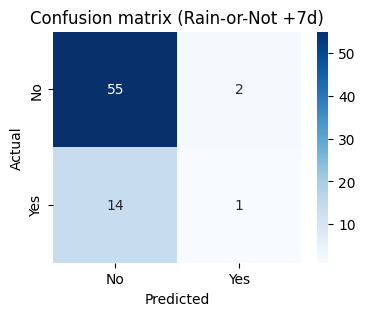

Top classifier features:
 temp_max_mean_7        0.138672
temp_min_mean_7        0.138543
dayofyear_cos          0.133492
temp_week_range        0.112061
dayofyear_sin          0.101711
precip_recent_mean     0.073822
precip_last_7          0.072966
precip_last_3          0.047040
precip_hours_last_7    0.045986
precip_last_1          0.028932
dtype: float64
Saved classifier to: models/rain_or_not/25506751_rain_model.pkl


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import os

# train classifier
clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced')
clf.fit(X_train_clf, y_train_clf)

# predict
y_pred_clf = clf.predict(X_test_clf)
y_proba_clf = clf.predict_proba(X_test_clf)[:,1]

# metrics
acc = accuracy_score(y_test_clf, y_pred_clf)
auc = roc_auc_score(y_test_clf, y_proba_clf)
print("Classifier Accuracy:", acc)
print("Classifier ROC AUC:", auc)
print("\nClassification report:\n", classification_report(y_test_clf, y_pred_clf))

# confusion matrix
cm = confusion_matrix(y_test_clf, y_pred_clf)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No","Yes"], yticklabels=["No","Yes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix (Rain-or-Not +7d)")
plt.show()

# feature importances
fi_clf = pd.Series(clf.feature_importances_, index=X_train_clf.columns).sort_values(ascending=False)
print("Top classifier features:\n", fi_clf.head(10))

# save model
os.makedirs("models/rain_or_not", exist_ok=True)
clf_path = f"models/rain_or_not/25506751_rain_model.pkl"
joblib.dump(clf, clf_path)
print("Saved classifier to:", clf_path)


# H.2 Train & Evaluate Regression (Experiment 2 — Precipitation next 3 days)

In [19]:
%pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 20.2 MB/s eta 0:00:0000:010:02
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.0
    Uninstalling scikit-learn-1.7.0:
      Successfully uninstalled scikit-learn-1.7.0

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Regression MAE: 4.395943749999999
Regression RMSE: 6.710765296317324
Regression R2: 0.30953446756834946


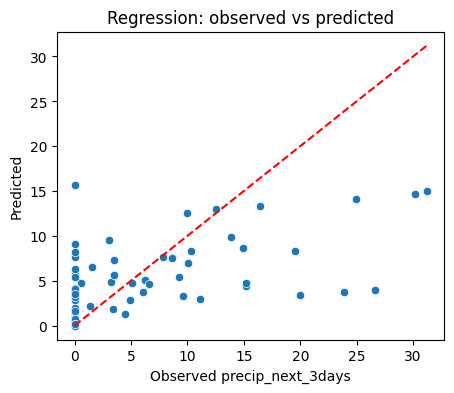

Top regression features:
 dayofyear_cos          0.205735
dayofyear_sin          0.163179
temp_max_mean_7        0.153528
temp_min_mean_7        0.126176
temp_week_range        0.069940
precip_last_7          0.064602
precip_last_3          0.062599
precip_recent_mean     0.052427
precip_hours_last_7    0.029102
precip_last_1          0.020364
dtype: float64
Saved regressor to: models/precipitation_fall/25506751_precip_model.pkl


In [20]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

reg = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
reg.fit(X_train_reg, y_train_reg)

y_pred_reg = reg.predict(X_test_reg)

from sklearn.metrics import mean_squared_error
import numpy as np

mae  = mean_absolute_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))   # <-- change here
r2   = r2_score(y_test_reg, y_pred_reg)

print("Regression MAE:", mae)
print("Regression RMSE:", rmse)
print("Regression R2:",  r2)


# scatter observed vs predicted
plt.figure(figsize=(5,4))
sns.scatterplot(x=y_test_reg, y=y_pred_reg)
plt.xlabel("Observed precip_next_3days")
plt.ylabel("Predicted")
plt.title("Regression: observed vs predicted")
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], color="red", linestyle="--")
plt.show()

# top features
fi_reg = pd.Series(reg.feature_importances_, index=X_train_reg.columns).sort_values(ascending=False)
print("Top regression features:\n", fi_reg.head(10))

# save regressor
os.makedirs("models/precipitation_fall", exist_ok=True)
reg_path = f"models/precipitation_fall/25506751_precip_model.pkl"
joblib.dump(reg, reg_path)
print("Saved regressor to:", reg_path)
